In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.coordinates import SkyCoord

from astropy import constants as const
from astropy import units as u

import seaborn as sns

In [2]:
from astropy.table import Table

groups = Table.read(r"C:\Users\caeho\OneDrive\Documents\University of Rochester REU\SDSS_DR7_Mr20_groups.dat2",
                    format='ascii.commented_header')
groups

ID,RA,DEC,z,N,Mr_tot,g_r_tot,sigma_v,R_perp,rms,r_edge
int32,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64
1,38.049133,0.224026,0.05402,1,-20.032,0.926,0.0,0.0,1.0,1.82
2,38.297181,0.04856,0.05406,3,-22.188,0.842,82.9,0.425,1.0,1.64
3,55.978967,0.526755,0.04028,2,-21.607,0.749,126.1,0.187,1.0,0.77
4,56.265446,0.618429,0.10564,1,-20.256,0.797,0.0,0.0,1.0,2.11
5,56.949131,0.57728,0.10006,1,-20.163,0.686,0.0,0.0,0.988,2.11
6,37.895509,1.003827,0.05442,1,-19.949,0.908,0.0,0.0,1.0,0.12
7,38.08029,0.594821,0.0212,2,-21.163,0.866,264.8,0.373,1.0,0.4
8,38.396365,0.962288,0.07265,1,-21.051,0.968,0.0,0.0,1.0,0.32
9,38.907034,1.031707,0.06714,1,-20.795,0.428,0.0,0.0,1.0,0.06


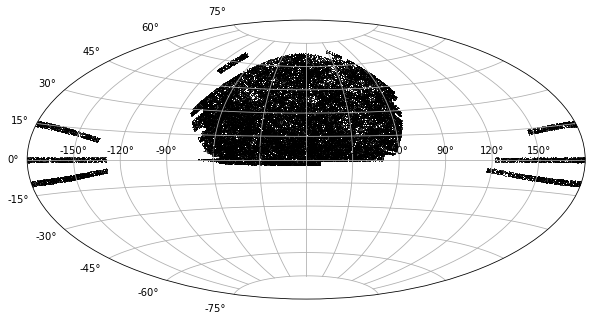

In [3]:
import astropy.units as u
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord

plt.rcParams["figure.figsize"] = (10,6) #increase size of figure

#eq = SkyCoord(180-Mr20['RA'], Mr20['DEC'], unit=u.deg)
#gal = eq.galactic

gal = SkyCoord(ra=180-groups['RA'], dec=groups['DEC'], unit=u.deg)


plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(gal.ra.wrap_at('180d').radian,
            gal.dec.radian, marker='o', c='k', s=1, lw=0); #added same marker appearance as above code

In [4]:
dwarf_table = Table.read('dwarf_table.txt', format = 'ascii.commented_header')
dwarf_table[:5]

aimc,IN_DR7_LSS,RA,DEC,Z,ELPETRO_ABSMAG_r,u_r,sSFR,HImass,flag3727,t3,Z12logOH,Zerr,logNO,NOerr,vflag_VF,ID,BPTclass,2D_neighbor_ID,2D_neighbor_dist,2D_neighbor_ID_vir,2D_neighbor_dist_vir,3D_neighbor_ID,3D_neighbor_dist,3D_neighbor_ID_vir,3D_neighbor_dist_vir
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64
0.0,1.0,147.17645340393182,-0.3540349522432606,0.006282840855419636,-15.534673690795898,1.5979467332363129,-9.897252082824707,nan,nan,nan,nan,nan,nan,nan,2,12,1.0,49,0.18150554228021565,585714,1.3634632510011546,573,0.3210655024172438,208,2.3657856725525463
106.68,1.0,146.85676432411947,-0.27409664376066756,0.02196459472179413,-16.7003231048584,1.6220477223396301,-9.639364242553711,nan,nan,nan,nan,nan,nan,nan,2,31,1.0,79,0.6704515586457357,92,2.414294367856323,80,0.9556330809587631,585700,3.7385754919749274
0.0,1.0,146.19277353258968,-0.6882589506846374,0.004080323036760092,-15.290872573852539,1.220979243516922,-9.548693656921387,nan,nan,nan,nan,nan,nan,nan,2,44,1.0,585695,0.035663331434249095,639857,0.46035331496314846,585695,0.221530846641702,585695,2.8927174640703734
199.39,1.0,146.00780426178756,-0.6422574964819474,0.004776299931108952,-15.831652641296387,0.7728094607591629,-7.982375621795654,nan,0.0,1.5717060395681055,7.73051787768279,0.0179600111522654,-0.5320566539047968,0.44255404846002694,2,45,1.0,585695,0.006393284307917346,585695,0.08348257342324528,639857,0.6010801341408164,639857,7.109919536505821
0.0,1.0,146.6190367018052,-0.43434631860351913,0.006036635022610426,-16.34455108642578,1.7559601366519928,-9.769034385681152,nan,nan,nan,nan,nan,nan,nan,2,49,1.0,585714,0.07059729101415332,585714,0.4172620229334301,585714,0.3596492056527832,585714,2.125689993784549


### Distance Method #1: 2D Distance 

Calculating the relative velocity b/t each galaxy

Equation to calculate relative velocity: $v_{rel} = |z_{a} - z_{b}|c$

All neighbors galaxies have a maximum relative velocity: $v_{rel} < 300  km/s$

In [5]:
h=1
H0 = 100*h*u.km/u.s/u.Mpc #Hubble's Constant

#creating the new columns
dwarf_table['2D_group_ID'] = -1
dwarf_table['2D_group_dist'] = np.nan

#columns for virial radius normalization 
dwarf_table['2D_group_ID_vir'] = -1
dwarf_table['2D_group_dist_vir'] = np.nan




for i in range(len(dwarf_table)):
    neighbor_list=(abs(dwarf_table['Z'][i]-groups['z'])*const.c) < 300*u.km/u.s #galaxies in relative velocity constraint
    
    if np.sum(neighbor_list)>0:
   
        #avg distance to systems (r average)
        avg_dist = .5*(const.c.to('km/s')*(dwarf_table['Z'][i]+groups['z'][neighbor_list])/H0) 

        #galaxy positions to calcuate their separation
        dwarf_pos = SkyCoord(ra=dwarf_table['RA'][i]*u.degree, dec=dwarf_table['DEC'][i]*u.degree, distance=avg_dist)
        neighbor_pos = SkyCoord(ra=groups['RA'][neighbor_list]*u.degree, 
                                dec=groups['DEC'][neighbor_list]*u.degree, distance=avg_dist)

        neighbor_dist=neighbor_pos.separation_3d(dwarf_pos) #separation calculation of all possible neighbors

        nearby_neigh_index = np.argmin(neighbor_dist) #finding closest neighbor

        dwarf_table['2D_group_dist'][i] = neighbor_dist[nearby_neigh_index].value #unit Mpc, adding to dwarf table

        neighbor_id = groups['ID'][neighbor_list] 
        dwarf_table['2D_group_ID'][i] = neighbor_id[nearby_neigh_index] #adding neighbor galaxy's ID to dwarf table


        # Doing calculation with virial radius normalization


        r_vir = groups['rms'][neighbor_list] # calculating virial radius of all neighboring galaxies


        neighbor_dist_vir = neighbor_dist / r_vir # normalizing distance

        nearby_neigh_index_vir = np.nanargmin(neighbor_dist_vir) #finding closest neighbor with normalized virial distance

        dwarf_table['2D_group_dist_vir'][i] = neighbor_dist_vir[nearby_neigh_index_vir].value #unit , adding to dwarf table


        dwarf_table['2D_group_ID_vir'][i] = neighbor_id[nearby_neigh_index_vir] #adding neighbor galaxy's ID to dwarf table
    

## 3D Method

In [6]:
#creating the new columns
dwarf_table['3D_group_ID'] = -1
dwarf_table['3D_group_dist'] = np.nan

#columns for virial radius normalization 
dwarf_table['3D_group_ID_vir'] = -1
dwarf_table['3D_group_dist_vir'] = np.nan

h=1
H0 = 100*h*u.km/u.s/u.Mpc #Hubble's Constant




for i in range(len(dwarf_table)):
    
    #distances to systems
    dwarf_r = const.c.to('km/s')*dwarf_table['Z'][i]/H0 
    groups_r = const.c.to('km/s')*groups['z']/H0

    
    #galaxy positions to calcuate their separation
    dwarf_pos = SkyCoord(ra=dwarf_table['RA'][i]*u.degree, dec=dwarf_table['DEC'][i]*u.degree, distance=dwarf_r)
    groups_pos = SkyCoord(ra=groups['RA']*u.degree, 
                            dec=groups['DEC']*u.degree, distance=groups_r)
    neighbor_dist=groups_pos.separation_3d(dwarf_pos)
    
    nearby_neigh_index = np.argmin(neighbor_dist) #finding the nearest neighbor
    
    
    dwarf_table['3D_group_dist'][i] = neighbor_dist[nearby_neigh_index].value #unit Mpc
     
    neighbor_id = groups['ID']
    dwarf_table['3D_group_ID'][i] = neighbor_id[nearby_neigh_index] #ID# of the closest neighbor galaxy
    
    # Doing calculation with virial radius normalization
    
    
    
    r_vir = groups['rms'] # calculating virial radius of all neighboring galaxies
    
    
    neighbor_dist_vir = neighbor_dist / r_vir # normalizing distance
    

    
    nearby_neigh_index_vir = np.nanargmin(neighbor_dist_vir) #finding closest neighbor with normalized virial distance
    
    dwarf_table['3D_group_dist_vir'][i] = neighbor_dist_vir[nearby_neigh_index_vir].value #unit , adding to dwarf table
    
    
    neighbor_id = groups['ID']
    dwarf_table['3D_group_ID_vir'][i] = neighbor_id[nearby_neigh_index_vir] #adding neighbor galaxy's ID to dwarf table

In [16]:
dwarf_table

aimc,IN_DR7_LSS,RA,DEC,Z,ELPETRO_ABSMAG_r,u_r,sSFR,HImass,flag3727,t3,Z12logOH,Zerr,logNO,NOerr,vflag_VF,ID,BPTclass,2D_neighbor_ID,2D_neighbor_dist,2D_neighbor_ID_vir,2D_neighbor_dist_vir,3D_neighbor_ID,3D_neighbor_dist,3D_neighbor_ID_vir,3D_neighbor_dist_vir,2D_group_ID,2D_group_dist,2D_group_ID_vir,2D_group_dist_vir,3D_group_ID,3D_group_dist,3D_group_ID_vir,3D_group_dist_vir
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64
0.0,1.0,147.17645340393182,-0.3540349522432606,0.006282840855419636,-15.534673690795898,1.5979467332363129,-9.897252082824707,nan,nan,nan,nan,nan,nan,nan,2,12,1.0,49,0.18150554228021565,585714,1.3634632510011546,573,0.3210655024172438,208,2.3657856725525463,-1,nan,-1,nan,15644,41.4125128116787,2539,41.76447666154416
106.68,1.0,146.85676432411947,-0.27409664376066756,0.02196459472179413,-16.7003231048584,1.6220477223396301,-9.639364242553711,nan,nan,nan,nan,nan,nan,nan,2,31,1.0,79,0.6704515586457357,92,2.414294367856323,80,0.9556330809587631,585700,3.7385754919749274,4270,0.8122744988884393,4270,0.8348144901217259,4270,1.337840690743606,4270,1.3749647386881871
0.0,1.0,146.19277353258968,-0.6882589506846374,0.004080323036760092,-15.290872573852539,1.220979243516922,-9.548693656921387,nan,nan,nan,nan,nan,nan,nan,2,44,1.0,585695,0.035663331434249095,639857,0.46035331496314846,585695,0.221530846641702,585695,2.8927174640703734,-1,nan,-1,nan,15644,47.99876009341575,2539,48.37100908551739
199.39,1.0,146.00780426178756,-0.6422574964819474,0.004776299931108952,-15.831652641296387,0.7728094607591629,-7.982375621795654,nan,0.0,1.5717060395681055,7.73051787768279,0.0179600111522654,-0.5320566539047968,0.44255404846002694,2,45,1.0,585695,0.006393284307917346,585695,0.08348257342324528,639857,0.6010801341408164,639857,7.109919536505821,-1,nan,-1,nan,15644,45.91917727954949,2539,46.289567183583294
0.0,1.0,146.6190367018052,-0.43434631860351913,0.006036635022610426,-16.34455108642578,1.7559601366519928,-9.769034385681152,nan,nan,nan,nan,nan,nan,nan,2,49,1.0,585714,0.07059729101415332,585714,0.4172620229334301,585714,0.3596492056527832,585714,2.125689993784549,-1,nan,-1,nan,15644,42.14864050680927,2539,42.50789399533266
21.37,1.0,146.28299647851426,0.0641463074401177,0.021579895168542862,-16.594152450561523,2.861306369304657,-10.189197540283203,nan,nan,nan,nan,nan,nan,nan,2,91,1.0,80,0.038323438909891316,92,0.17226127693210824,92,0.10268810550034341,92,0.3052372880294029,4270,0.05797735488734115,4270,0.059586181795828516,4270,0.10726974463531468,4270,0.11024639736414664
0.0,1.0,145.3209420527222,0.771115298508063,0.00658948952332139,-14.810564994812012,1.925416886806488,-9.748167991638184,nan,0.0,3.57494352664153,7.007952737418975,0.2935407103312847,-0.9956427104372425,0.4090425521885854,2,186,1.0,208,0.16133006586884238,208,0.576340261650062,208,0.6516081633066332,208,2.3278241244801396,-1,nan,-1,nan,15644,40.473829573781074,2539,40.86689915122829
-99.0,1.0,145.4212238164792,0.5359777701124617,0.1459859162569046,-14.866592407226562,-3.4473413228988647,nan,nan,nan,nan,nan,nan,nan,nan,9,209,nan,206,0.23624643923335842,206,0.5428900018158784,206,0.53709656480362,206,1.2342380947105809,-1,nan,-1,nan,2044,121.47968950345378,16258,124.59858941327198
0.0,1.0,146.26576246056774,1.2304320197663696,0.006355164106935263,-14.2352876663208,1.6930833458900452,-9.700735092163086,nan,0.0,4.040375795270858,7.048466376827344,0.3785143362106475,-1.2323400004904403,0.5170923842950506,2,238,1.0,55137,0.13915957213413985,55243,0.8924983833408165,55137,0.18685834815465546,208,1.4133282793228592,-1,nan,-1,nan,15644,41.16043878248401,2539,41.549262875655884


## Separate table for the 2D distance 

In [8]:


mask = dwarf_table['2D_group_ID']!= -1     #removing objects that are not galaxies
dwarf_table_2D = dwarf_table[mask]

dwarf_table_2D

aimc,IN_DR7_LSS,RA,DEC,Z,ELPETRO_ABSMAG_r,u_r,sSFR,HImass,flag3727,t3,Z12logOH,Zerr,logNO,NOerr,vflag_VF,ID,BPTclass,2D_neighbor_ID,2D_neighbor_dist,2D_neighbor_ID_vir,2D_neighbor_dist_vir,3D_neighbor_ID,3D_neighbor_dist,3D_neighbor_ID_vir,3D_neighbor_dist_vir,2D_group_ID,2D_group_dist,2D_group_ID_vir,2D_group_dist_vir,3D_group_ID,3D_group_dist,3D_group_ID_vir,3D_group_dist_vir
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64
106.68,1.0,146.85676432411947,-0.27409664376066756,0.02196459472179413,-16.7003231048584,1.6220477223396301,-9.639364242553711,nan,nan,nan,nan,nan,nan,nan,2,31,1.0,79,0.6704515586457357,92,2.414294367856323,80,0.9556330809587631,585700,3.7385754919749274,4270,0.8122744988884393,4270,0.8348144901217259,4270,1.337840690743606,4270,1.3749647386881871
21.37,1.0,146.28299647851426,0.0641463074401177,0.021579895168542862,-16.594152450561523,2.861306369304657,-10.189197540283203,nan,nan,nan,nan,nan,nan,nan,2,91,1.0,80,0.038323438909891316,92,0.17226127693210824,92,0.10268810550034341,92,0.3052372880294029,4270,0.05797735488734115,4270,0.059586181795828516,4270,0.10726974463531468,4270,0.11024639736414664
100.5,1.0,146.53086174958216,0.781908767844665,0.02025769092142582,-16.431692123413086,2.4716179072856903,-9.588902473449707,9.31,0.0,4.419694003996986,6.953538822870812,0.33596775239087995,-1.2294645924089984,0.4681862138357456,2,289,1.0,296,0.3160018638066713,296,1.4188280832387938,323,0.5037906584927532,296,2.8296931864313977,2539,1.6396300861191246,2539,1.6396300861191246,2539,1.6458507189025815,2539,1.6458507189025815
51.48,1.0,147.83560177025691,0.8997165632924147,0.020493237301707268,-16.619539260864258,1.6862696409225464,-9.780756950378418,nan,nan,nan,nan,nan,nan,nan,2,567,1.0,585,0.2369676597204177,585,0.8694086806522504,585,0.2780576563053593,585,1.020163428203321,2539,0.3073475111216157,2539,0.3073475111216157,2539,0.9030335556757442,2539,0.9030335556757442
61.58,1.0,148.44052081323045,0.7867939603113092,0.02051127329468727,-16.596445083618164,1.6433095932006836,-9.7621431350708,9.07,nan,nan,nan,nan,nan,nan,2,677,1.0,624,0.1343098163915123,624,1.2909916715339467,567,0.6622767538819025,585,2.521902267209164,2539,0.5321262031276628,2539,0.5321262031276628,2539,1.04828589147542,2539,1.04828589147542
136.24,1.0,151.80959108402604,0.055765521446274856,0.02166339010000229,-16.63641929626465,1.199486032128334,-9.3024320602417,nan,nan,nan,nan,nan,nan,nan,2,1133,1.0,1353,0.6701466689863808,607110,2.088080729955921,1343,0.7457304293824428,1345,4.239763810777985,2294,0.7547385774025981,2294,0.8489747777307065,9740,1.4770727180809573,9740,1.610766322879997
1.0,1.0,151.48056199522557,0.6522017939674254,0.0210582185536623,-16.3584041595459,2.6675206422805786,-11.872618675231934,nan,nan,nan,nan,nan,nan,nan,2,1391,-1.0,1345,0.031190504681219287,607110,0.09029814701698359,607110,0.4164189738744056,607110,1.1539671542496432,2294,0.03182832741371439,2294,0.03580239304129853,2294,0.10045402623108184,2294,0.11299665492810106
-99.0,1.0,151.53620939925946,0.6883608156215566,0.02119605243206024,-16.356752395629883,2.3887422680854797,nan,nan,nan,nan,nan,nan,nan,nan,2,1392,nan,1391,0.07335787861005147,607110,0.2928227832860824,1353,0.16602814305763047,1345,0.6115709864672979,2294,0.10501709830026912,2294,0.11812946940412725,2294,0.33483216715022607,2294,0.3766391081554849
135.46,1.0,152.68095226901738,-0.6377681061918964,0.02110603079199791,-16.879552841186523,1.4309385418891907,-9.682833671569824,nan,nan,nan,nan,nan,nan,nan,2,1522,1.0,640322,0.43351405497566475,607279,2.3244917005573758,1589,0.668862509275086,607279,4.4161451349394145,9740,0.6079544869736367,9740,0.6629819923376628,9740,0.7818193867752098,9740,0.8525838459925952


## Saving Group Table

In [17]:
#dwarf_table.write('g_dwarf_table.txt', format = 'ascii.commented_header', overwrite = True)
dwarf_table_2D.write('g_dwarf_table_2D.txt', format = 'ascii.commented_header', overwrite = True)

# Test plot

In [10]:
dwarf_wall = dwarf_table['vflag_VF']==0
dwarf_void = dwarf_table['vflag_VF']==1
dwarf_other = ~(dwarf_wall | dwarf_void)

In [11]:
def profilehist(x, y, w=None, bins=10, uncertainty='stderr'):
    """Compute a profile histogram given x, y and optional weights.
    
    Parameters
    ----------
    x : (N,) array_like
        Sequence of values to be binned.
    y : (N,) array_like
        Data on which the statistic will be computed.
    w : None or (N,) array_like
        Weights for each data point y.
    bins : int or array_like
        If int, define equal-length bins given by data min/max range; else, user-defined bin edges.
    uncertainty : str
        'stderr' to compute standard error on the mean; 'sample' for sample uncertainty
        
    Returns
    -------
    xc : array of dtype float
        Bin centers in x.
    yavg : array of dtype float
        Average in each bin.
    yerr : array of dtype float
        Uncertainty in each bin (sample error or error on the mean).
    """
    # Default to equal weights in each bin.
    if w is None:
        w = np.ones_like(y, dtype=np.float64)

    # Compute weighted sums and construct the weighted means and uncertainties.
    (Y, E, W), edges, idx = binned_statistic(x, [w*y, w*y**2, w], bins=bins, statistic='sum')
    yavg = Y/W
    ystd = np.sqrt(E/W - yavg**2)
    yerr = ystd/np.sqrt(W)

    # Compute bin centers.
    xc = 0.5*(edges[1:] + edges[:-1])
    
    if uncertainty == 'sample':
        return xc, yavg, ystd
    elif uncertainty == 'stderr':
        return xc, yavg, yerr
    else:
        raise ValueError(f'uncertainty={uncertainty} unknown; allowed: "stderr" and "sample"')

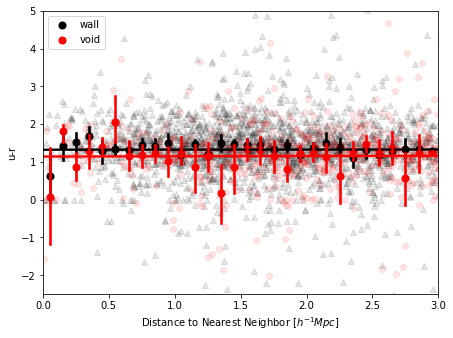

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)

for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d = dwarf_table['3D_group_dist_h'][select & sfd]
    #vals = dwarf_table['u_r'][select & sfd]
    
    d = dwarf_table['3D_group_dist'][select]
    vals = dwarf_table['u_r'][select]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,3,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
        
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='u-r', xlim=(0,3), ylim=(-2.5,5));
        
    ax.legend()
        
    #fig.savefig('group_sfd_ur_3D_LR.png')
    
    #fig.savefig('group_ur_3D_LR.png')

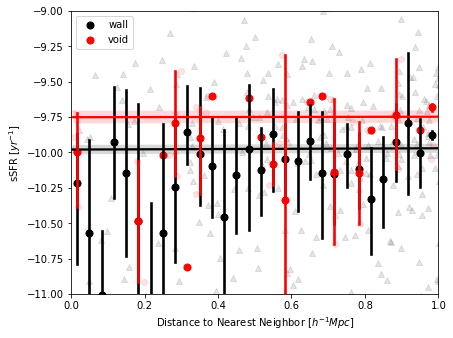

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)

for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d = dwarf_table['3D_group_dist_h'][select & sfd]
    #vals = dwarf_table['sSFR'][select & sfd]
    
    d = dwarf_table['3D_group_dist'][select]
    vals = dwarf_table['sSFR'][select]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
        
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='sSFR [$yr^{-1}]$', xlim=(0,1), ylim=(-11,-9));
        
    ax.legend()
        
    #fig.savefig('group_sfd_sSFR_3D_LR.png')
    
    #fig.savefig('group_sSFR_3D_LR.png')

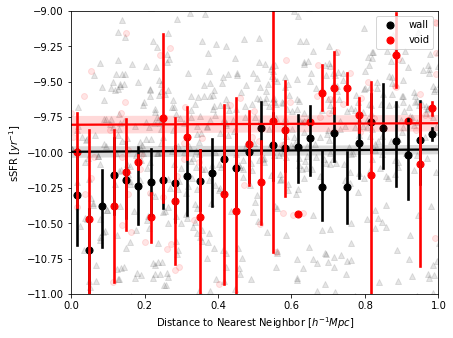

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)

for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d = dwarf_table['3D_group_dist_h'][select & sfd]
    #vals = dwarf_table['sSFR'][select & sfd]
    
    d = dwarf_table['2D_group_dist'][select]
    vals = dwarf_table['sSFR'][select]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
        
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='sSFR [$yr^{-1}]$', xlim=(0,1), ylim=(-11,-9));
        
    ax.legend()

(-2.0, 5.0)

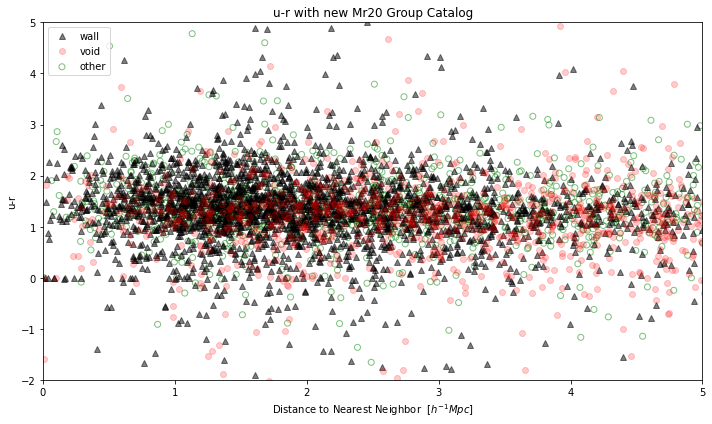

In [15]:
plt.figure(tight_layout = True)
plt.plot(dwarf_table['3D_group_dist'][dwarf_wall], dwarf_table['u_r'][dwarf_wall], "k^", alpha = 0.5, label = 'wall')
plt.plot(dwarf_table['3D_group_dist'][dwarf_void], dwarf_table['u_r'][dwarf_void], "ro", alpha = 0.2, label = 'void')
plt.scatter(dwarf_table['3D_group_dist'][dwarf_other], dwarf_table['u_r'][dwarf_other], facecolors='none',
            edgecolors='g', alpha = 0.5, label = 'other')
plt.legend()
plt.xlabel('Distance to Nearest Neighbor  [$h^{-1}Mpc]$')
plt.title('u-r with new Mr20 Group Catalog')
plt.ylabel('u-r');
plt.xlim(0, 5)
plt.ylim(-2,5)